In [2]:
import pandas as pd
import streamlit as st
import chardet
import re
import numpy as np
import pickle

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize


nltk.download('averaged_perceptron_tagger')  # for pos_tag
nltk.download('wordnet')              # for WordNetLemmatizer
nltk.download('omw-1.4')              # for extended WordNet lemmatization
nltk.download('stopwords')            # if using stop words



from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, classification_report


ModuleNotFoundError: No module named 'matplotlib.backends.registry'

In [ ]:


# Step 1: Detect encoding
file_path = 'F:/rating/multiclass_review_prediction (3).csv'

with open(file_path, 'rb') as f:
    raw_data = f.read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']
    print(f"Detected encoding: {encoding}")

# Step 2: Read CSV with detected encoding
df = pd.read_csv(file_path, encoding=encoding)

df.to_csv('women_cloth_reviews_final.csv')




Detected encoding: MacRoman


In [ ]:
# drop unwanted columns

data = pd.read_csv('F:/rating/women_cloth_reviews_final.csv')
data = data.drop(columns=['Unnamed: 0'])
data.shape


(23486, 11)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Sno                      23486 non-null  int64 
 1   Clothing.ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review.Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended.IND          23486 non-null  int64 
 7   Positive.Feedback.Count  23486 non-null  int64 
 8   Division.Name            23470 non-null  object
 9   Department.Name          23469 non-null  object
 10  Class.Name               23469 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [ ]:
# find null values
data.isnull().sum()

Sno                           0
Clothing.ID                   0
Age                           0
Title                      3810
Review.Text                 845
Rating                        0
Recommended.IND               0
Positive.Feedback.Count       0
Division.Name                16
Department.Name              17
Class.Name                   17
dtype: int64

In [ ]:
# drop null values in review_text
data = data.dropna(subset=['Review.Text'],axis=0)
data.head()

,Sno,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
0,7219,1092,34,Beware if you're fuller in the chest,I loved the lace detailing all over this dress...,3,1,122,General,Dresses,Dresses
1,1295,1095,29,NaN,I've been on the hunt for the perfect dress to...,5,1,117,General,Dresses,Dresses
2,7766,986,43,Quality does not merit cost,I generally don't write bad reviews but there ...,1,0,108,General,Jackets,Jackets
3,19095,1121,35,A navy trench-yes!,I am a big fan of trench coats and i love that...,5,1,99,General,Jackets,Outerwear
4,13211,1078,23,Super flattering,Beautiful Dressthis Is My Favorite Dress I'Ve ...,5,1,98,General,Dresses,Dresses


In [ ]:
data.isnull().sum()

Sno                           0
Clothing.ID                   0
Age                           0
Title                      2966
Review.Text                   0
Rating                        0
Recommended.IND               0
Positive.Feedback.Count       0
Division.Name                15
Department.Name              16
Class.Name                   16
dtype: int64

In [ ]:
# fill null values based on most frequent ocuurence for division name, deparment name & class name
data['Division.Name'] = data['Division.Name'].fillna(data['Division.Name'].mode()[0])
data['Department.Name'] = data['Department.Name'].fillna(data['Department.Name'].mode()[0])
data['Class.Name'] = data['Class.Name'].fillna(data['Class.Name'].mode()[0])

In [ ]:
# fill null values in title features as populated as 'unassigned title'
data['Title'] = data['Title'].fillna('Unassigned Title')

In [ ]:
# 1. Sentiment scores


# to estimate polarity for reviews 
data['polarity'] = data['Review.Text'].apply(lambda x: TextBlob(x).sentiment.polarity)


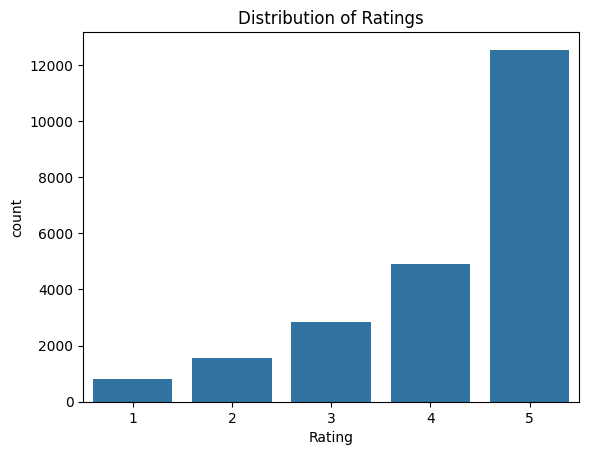

In [ ]:
#2. Rating distribution


sns.countplot(x='Rating', data=data)
plt.title('Distribution of Ratings')
plt.show("plot.png")

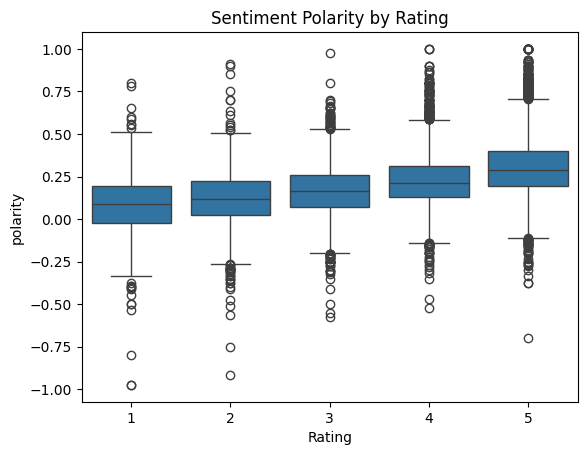

In [ ]:
# polarity vs rating 
sns.boxplot(x='Rating', y='polarity', data=data)
plt.title('Sentiment Polarity by Rating')
plt.show()

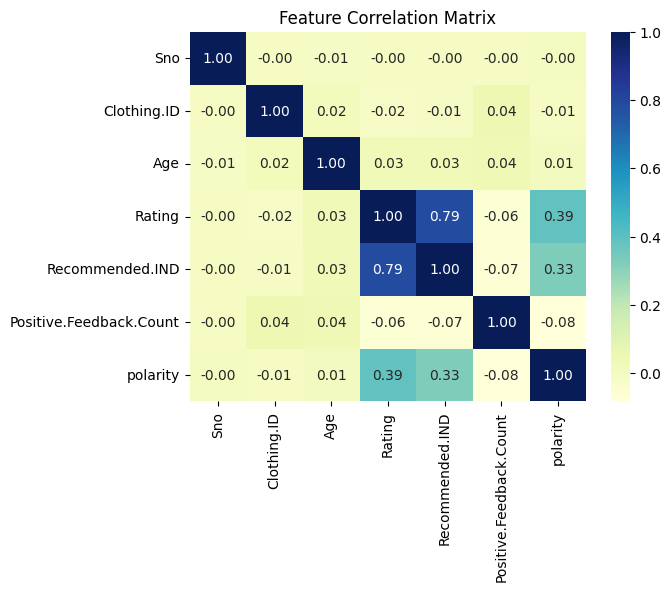

In [ ]:
## corelation matrix
corr = data.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


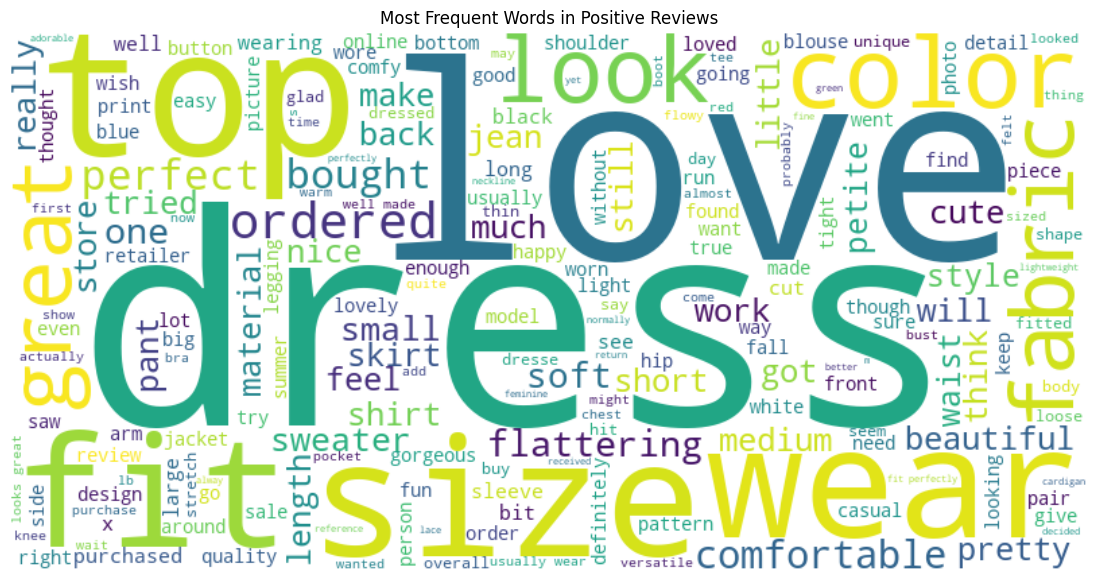

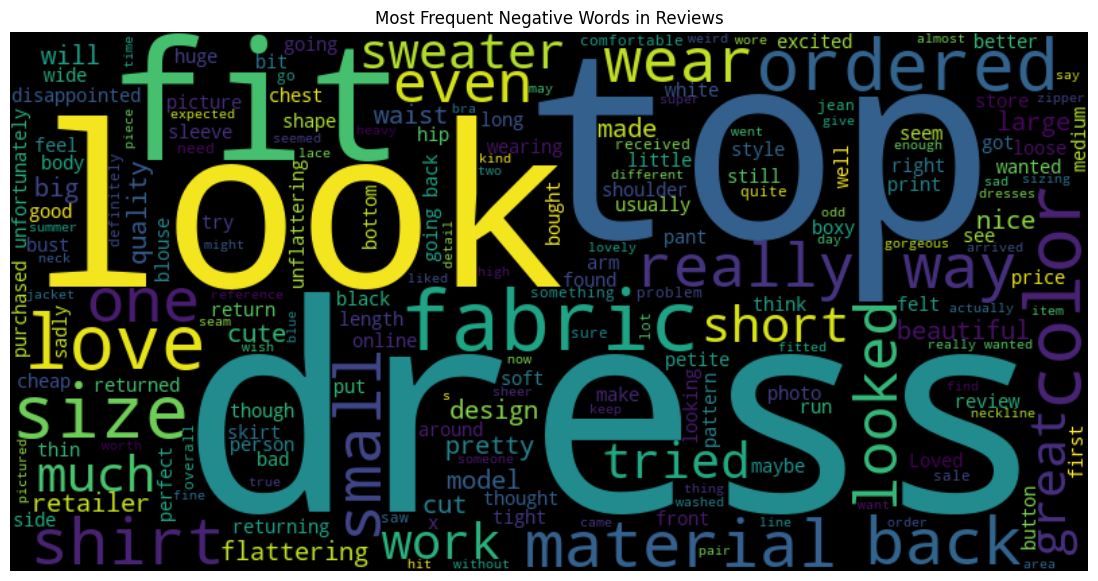

In [ ]:
 # Word Cloud of Frequent Terms



positive = data[ data['Recommended.IND'] == 1]
train_pos = positive['Review.Text']
negative= data[ data['Recommended.IND'] == 0]
train_neg = negative['Review.Text']

P_text = " ".join(positive['Review.Text'].tolist())
wc = WordCloud(width=800, height=400, background_color='white').generate(P_text)
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Positive Reviews')
plt.show()

n_text = " ".join(negative['Review.Text'].tolist())
wc1 = WordCloud(width=800, height=400, background_color='black').generate(n_text)

plt.figure(figsize=(15, 7))
plt.imshow(wc1, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Negative Words in Reviews')
plt.show()

In [ ]:
#Defining Target Variable (y) and Feature Variables (X)

X = data['Review.Text']
y = data['Rating']

In [ ]:
data['Rating'].value_counts()

Rating
5    12540
4     4908
3     2823
2     1549
1      821
Name: count, dtype: int64

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15848,), (6793,), (15848,), (6793,))

In [ ]:
# stop words & lemmatization

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def reduce_lengthening(text):
    # Replace 3 or more repeated letters with 2 letters
    pattern = re.compile(r'(.)\1{2,}', re.DOTALL)
    return pattern.sub(r'\1\1', text)



def preprocess(text):
    text = text.lower()
    text = reduce_lengthening(text)             # <--- apply here
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
# TF-IDF with custom preprocessor
tfidf = TfidfVectorizer(preprocessor=preprocess)


# Build pipeline
pipeline1 = Pipeline([
    ('tfidf', tfidf),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipeline1.fit(X_train, y_train)
feature_names = tfidf.get_feature_names_out()
feature_names
y_pred_rf = pipeline1.predict(X_test)
y_pred_rf

# model evalution

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))



[[   6    9   19    7  205]
 [   2   10   46   15  392]
 [   3    8   62   38  736]
 [   0    0   27   54 1392]
 [   0    0    6   17 3739]]
              precision    recall  f1-score   support

           1       0.55      0.02      0.05       246
           2       0.37      0.02      0.04       465
           3       0.39      0.07      0.12       847
           4       0.41      0.04      0.07      1473
           5       0.58      0.99      0.73      3762

    accuracy                           0.57      6793
   macro avg       0.46      0.23      0.20      6793
weighted avg       0.50      0.57      0.44      6793



In [ ]:
# Build pipeline for multinominal Naive bayes & using TDIDF vectoriser
tfidf = TfidfVectorizer(preprocessor=preprocess)

pipeline2 = Pipeline([
    ('tfidf', tfidf),
    ('clf1', MultinomialNB())
])

pipeline2.fit(X_train, y_train)
feature_names = tfidf.get_feature_names_out()
print(len(feature_names))

y_pred_mb1 = pipeline2.predict(X_test)
y_pred_mb1


# model evalution for mb 

print(confusion_matrix(y_test, y_pred_mb1))
print(classification_report(y_test, y_pred_mb1))

13357
[[   0    0    1    2  243]
 [   0    0    4    9  452]
 [   0    0    3    5  839]
 [   0    0    0    1 1472]
 [   0    0    0    1 3761]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       246
           2       0.00      0.00      0.00       465
           3       0.38      0.00      0.01       847
           4       0.06      0.00      0.00      1473
           5       0.56      1.00      0.71      3762

    accuracy                           0.55      6793
   macro avg       0.20      0.20      0.14      6793
weighted avg       0.37      0.55      0.40      6793



f:\rating\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
f:\rating\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
f:\rating\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Build pipeline for multinominal Naive bayes & using Count vectoriser
cv = CountVectorizer(lowercase=True,stop_words='english')

pipeline3 = Pipeline([
    ('cv', cv),
    ('clf1', MultinomialNB())
])

pipeline3.fit(X_train, y_train)
feature_names = cv.get_feature_names_out()
print(len(feature_names))

y_pred_mb2 = pipeline3.predict(X_test)
y_pred_mb2


# model evalution for mb 

print(confusion_matrix(y_test, y_pred_mb2))
print(classification_report(y_test, y_pred_mb2))

12597
[[  13   42  113   32   46]
 [   7   34  247   94   83]
 [   2   27  341  264  213]
 [   1   10  151  467  844]
 [   1    5   47  342 3367]]
              precision    recall  f1-score   support

           1       0.54      0.05      0.10       246
           2       0.29      0.07      0.12       465
           3       0.38      0.40      0.39       847
           4       0.39      0.32      0.35      1473
           5       0.74      0.90      0.81      3762

    accuracy                           0.62      6793
   macro avg       0.47      0.35      0.35      6793
weighted avg       0.58      0.62      0.58      6793



In [ ]:
# TF-IDF with custom preprocessor
cv = CountVectorizer(lowercase=True,stop_words='english')


# Build pipeline
pipeline4 = Pipeline([
    ('cv', cv),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipeline4.fit(X_train, y_train)

y_pred_rf1 = pipeline4.predict(X_test)
y_pred_rf1

# model evalution

print(confusion_matrix(y_test, y_pred_rf1))
print(classification_report(y_test, y_pred_rf1))

[[  12   17   32    4  181]
 [   8   17   69   22  349]
 [   2   22   96   47  680]
 [   0    1   43   56 1373]
 [   1    0    7   28 3726]]
              precision    recall  f1-score   support

           1       0.52      0.05      0.09       246
           2       0.30      0.04      0.07       465
           3       0.39      0.11      0.18       847
           4       0.36      0.04      0.07      1473
           5       0.59      0.99      0.74      3762

    accuracy                           0.58      6793
   macro avg       0.43      0.25      0.23      6793
weighted avg       0.49      0.58      0.45      6793



In [ ]:
## reclassify rating 

data.replace({'Rating': { 1:0, 2:0, 3:0, 4:1, 5:1 }}, inplace=True)
y = data['Rating']
X = data['Review.Text']

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((15848,), (6793,), (15848,), (6793,))

In [ ]:

# Build pipeline for multinominal Naive bayes &  Count vectoriser in reclassified rating feature

cv = CountVectorizer(lowercase=True,stop_words='english')

pipeline5 = Pipeline([
    ('cv', cv),
    ('clf1', MultinomialNB())
])


pipeline5.fit(X_train1, y_train1)
feature_names = cv.get_feature_names_out()
print(len(feature_names))

y_pred_mb2 = pipeline5.predict(X_test1)
y_pred_mb2


# model evalution for mb 

print(confusion_matrix(y_test1, y_pred_mb2))
print(classification_report(y_test1, y_pred_mb2))

12496
[[1056  502]
 [ 334 4901]]
              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1558
           1       0.91      0.94      0.92      5235

    accuracy                           0.88      6793
   macro avg       0.83      0.81      0.82      6793
weighted avg       0.87      0.88      0.87      6793



In [ ]:

print(pipeline5.predict_proba(["wosrt product"]))

[[0.4555395 0.5444605]]


In [ ]:
def change_rating(data):

    probs  = pipeline5.predict_proba(data)

    max_probs = np.max(probs, axis=1)

    ratings = np.round(max_probs * 5).astype(int)

    ratings = np.clip(ratings, 1, 5)
    return ratings

In [ ]:


probs  = pipeline5.predict_proba((["worst product"]))

max_probs = np.max(probs, axis=1)
print(max_probs)

bins = [0.2, 0.4, 0.65, 0.8, 1.0]

ratings = np.digitize(max_probs, bins, right=True) 

ratings

[0.97182244]


array([4])

In [ ]:
new_pred = change_rating(["wosrt product"])
new_pred

array([3])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Fit the pipeline
pipeline3.fit(X_train1, y_train1)


# Predict on test data
y_pred_mb2 = pipeline3.predict(X_test1)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test1, y_pred_mb2))

print("\nClassification Report:")
print(classification_report(y_test1, y_pred_mb2))

# Custom rating function
def change_rating(data):
    probs = pipeline3.predict_proba(data)
    max_probs = np.max(probs, axis=1)
    ratings = np.round(max_probs * 5).astype(int)
    ratings = np.clip(ratings, 1, 5)
    return ratings

# Example usage
new_pred = change_rating(["totally disappointed worst product"])
print("Predicted Rating:", new_pred)

print(pipeline3.predict(["love this product"]))


Confusion Matrix:
[[1056  502]
 [ 334 4901]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1558
           1       0.91      0.94      0.92      5235

    accuracy                           0.88      6793
   macro avg       0.83      0.81      0.82      6793
weighted avg       0.87      0.88      0.87      6793

Predicted Rating: [5]
[1]


In [ ]:
# save the model (multinominal Naive bayes &  Count vectoriser in reclassified rating feature)

with open('multinomial_nb_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline3, file)